# Ejercicio 01: Segmentacion Simple

## 1 Segmentar de los dos patos. 

Lo primero es identificar la posición de los patos, a simple vista es fácil decir que el color dominante de la imagen es el azul y que en toda la imagen los únicos que no presentan en exceso este color son los patos así que podemos empezar por un código que denote los pixeles con intensidad azul baja e ignore los otros(o viceversa).

Para la primera prueba usaremos un umbral de 0 a 32, tomando en cuenta que la escala es de 0 a 255.

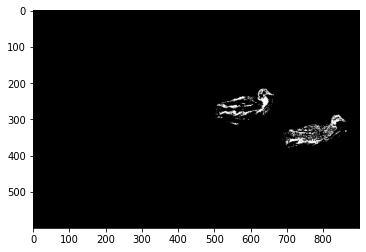

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io

def segregador_de_tonos_azul(im, minimo, maximo):
    dimenciones = im.shape
    y, x = dimenciones[0], dimenciones[1]
    plt.figure()
    im_blue = np.copy(im) # creo una copia de la imagen para preservar la original
    im_blue[:,:,0]=0
    im_blue[:,:,1]=0
    pixel0 = 0
    pixel1 = 255

    j = 0
    while j < y:
        i = 0
        while i < x :
            tono = im_blue[j][i][2]
        
            if minimo < tono < maximo:
                
                im_blue[j][i] = [pixel1, pixel1, pixel1, 255]

            else:
                
                im_blue[j][i] = [pixel0, pixel0, pixel0, 255]
            i += 1
        j += 1

    return im_blue

im = io.imread("IMG01.png")
im_blue = segregador_de_tonos_azul(im, 0, 32)
plt.imshow(im_blue)

El código funciona para identificar a los patos así que ahora debemos buscar los espacios que ocupan. Seria algo tedioso tener que crear un código que buscara los espacios de ambos patos al mismo tiempo por lo que se me ocurrió separa la en cuadrantes y ver cuales ocupa cada pato, para esto cree otro código que separa la imagen en cortes horizontales y verticales:

In [4]:
def dividir_en_hectarea(im, div_vert, div_hor):
    dimenciones = im.shape
    alto, ancho = dimenciones[0], dimenciones[1]
    x = ancho// div_vert
    y = alto//div_hor
    num_x = 1
    num_y = 1
    pixel = [255, 255, 255, 255]

    while num_x < div_vert:
        pos_x = num_x*x
        for j in range(alto):
            for k in range(-1,2):
                im[j][pos_x + k] = pixel
        num_x += 1

    while num_y < div_hor:
        pos_y = num_y*y
        for j in range(ancho):
            for k in range(-1,2):
                im[pos_y + k][j] = pixel
        num_y += 1

    return im


Tras ver la imagen anterior pareciera que ambos patos se encuentran ente los 200 y 400 pixeles visto desde arriba hacia abajo y a de los 450 a los 900 visto desde izquierda a derecha así que probaremos con una división de 4X3:

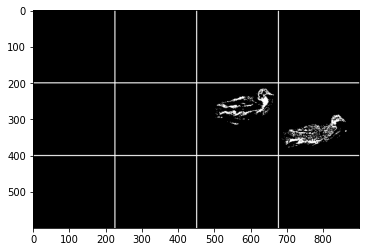

In [5]:
im_div = dividir_en_hectarea(im_blue, 4, 3)
plt.imshow(im_div)

Convenientemente un pato se encuentra en el cuadrante (2,1) y el otro en el cuadrante (3,1). Con esto podemos crear una función que encuentre los limites superiores he inferiores de los patos, luego crear una función que encuadre un espacio con los límites dados:

In [9]:
def encontrar_borde(im, cuadrante):
    dimenciones = im.shape
    y, x = dimenciones[0], dimenciones[1]
    espacio_x, espacio_y = x//4, y//3
    borde_x, borde_y = cuadrante[0], cuadrante[1]
    esquina_x_max = 0
    esquina_x_min = 1000
    esquina_y_max = 0
    esquina_y_min = 1000
    
    for j in range(espacio_y*(borde_y), espacio_y*(borde_y + 1)):
        for i in range(espacio_x*(borde_x), espacio_x*(borde_x + 1)):
            pixel = im[j][i][0]
            if pixel == 255:
                if i < esquina_x_min:
                    esquina_x_min = i

                if i > esquina_x_max:
                    esquina_x_max = i

                if j < esquina_y_min:
                    esquina_y_min = j

                if j > esquina_y_max:
                    esquina_y_max = j
   
    espacios = [[esquina_x_min, esquina_y_min],[esquina_x_max, esquina_y_max]]
    
    return espacios

def encuadrar(im, lista_limites):
    pixel_amarillo = [230, 230, 50, 255]
    for limites in lista_limites:
        x_min, y_min = limites[0][0] - 8, limites[0][1] - 8
        x_max, y_max = limites[1][0] + 10, limites[1][1] - 8
        
        for j in range(y_min, y_max):
            for i in range(x_min - 2, x_min + 2):
                
                im[j][i] = pixel_amarillo
                
        for j in range(y_min, y_max):
            for i in range(x_max - 2, x_max + 2):
                
                im[j][i] = pixel_amarillo    

        for i in range(x_min, x_max):
            for j in range(y_min - 2, y_min + 2):
               
                im[j][i] = pixel_amarillo
                
        for i in range(x_min, x_max):
            for j in range(y_max - 2, y_max + 2):
                
                im[j][i] = pixel_amarillo
                
    return im

Ya con todo esto podemos crear el código final:

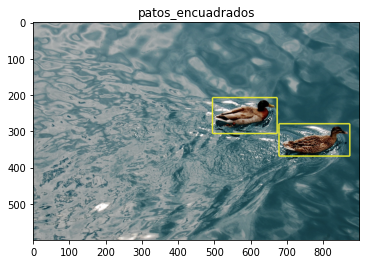

In [10]:
def encuadrar_patos(ruta, nombre):
    im = io.imread(ruta)
    im_blue = segregador_de_tonos_azul(im, 0, 32)
    cuadrantes = [[2,1],[3,1]]
    lista_espacios = [] 
    for cuadrante in cuadrantes:
        bordes = encontrar_borde(im_blue, cuadrante)
        lista_espacios.append(bordes)
    
    im = encuadrar(im, lista_espacios)

    plt.title("patos_encuadrados")
    plt.imshow(im)
    plt.show()
    io.imsave(nombre,im)

encuadrar_patos("IMG01.png", "patos_encuadrados.png")

## Cacule la longitud del lapiz en pixles.

Para este ejercicio podemos aplicar un filtro de tonos (al igual que el ejercicio anterior) que resaltar los pixeles con intensidad baja y disminuir los de intensidad alta para luego calcular los bordes superiores e inferiores del lápiz y así finalmente calcular su largo mediante Pitágoras:

In [18]:
def segregador_de_tonos(im, minimo, maximo):
    dimenciones = im.shape
    x, y = dimenciones[0], dimenciones[1]
    pixel0 = 0
    pixel1 = 255

    j = 0
    while j < y:
        i = 0
        while i < x :
            tono = im[i][j]
        
            if minimo < tono < maximo:
                im[i][j] = pixel1

            else:
                im[i][j] = pixel0
            i += 1
        j += 1

    return im

def calcular_largo(im):
    dimenciones = im.shape
    y, x = dimenciones[0], dimenciones[1]
    primer_punto = []
    ultimo_punto = []
    mas_largo = 0
    mas_corto = 1000
    j = 0
    while j < y:
        i = 0
        while i < x - 30:
            if im[j][i] == 255:
                if i < mas_corto:
                    mas_corto = i
                    primer_punto = [i,j]

                if i > mas_largo:
                    mas_largo = i
                    ultimo_punto = [i,j]

            i += 1
        j += 1

    delta_x = (abs(ultimo_punto[0] - primer_punto[0]))**2
    delta_y = (abs(ultimo_punto[1] - primer_punto[1]))**2
    hip = (delta_x + delta_y)**(1/2)

    return hip

Después de haber calculado el área solo faltaba escribir el resultado sobre la imagen,
lamentablemente no encontré funciones en la librería skimage que hicieran esto pero si lo habían para la librería Image por lo que cree una función que pasara la imagen de tipo skime a Image:

In [19]:
def trasformar_a_pixeles(im):
    dimenciones = im.shape
    y, x = dimenciones[0], dimenciones[1]
    im2 = Image.new('RGB', (x, y))

    j = 0
    while j < y:
        i = 0
        while i < x:
            color = im[j][i]
            pixel = tuple([color, color, color])
            im2.putpixel((i,j), pixel)
            i += 1
        j += 1
        
    return im2

y solo resta hacer un código para escribir sobre la imagen:

In [20]:
from PIL import ImageDraw, ImageFont

def escribir_texto(im, texto, pos_x, pos_y, tamaño_letra):
    font = ImageFont.truetype("Arial.ttf", tamaño_letra)
    draw = ImageDraw.Draw(im)
    draw.text((pos_x, pos_y), texto, font=font, fill="white")

Y lo juntamos todo en una función

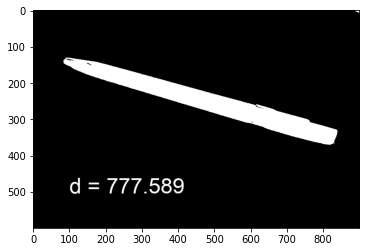

In [23]:
def calcular_largo_lapiz(ruta_imagen):
    im = io.imread(ruta_imagen)
    im = segregador_de_tonos(im, 0, 74)
    largo = calcular_largo(im)
    new_im = trasformar_a_pixeles(im)
    
    texto = f"d = {str(largo)[0:7]}"
    escribir_texto(new_im, texto, 100, 450, 60)
    
    plt.rcParams['image.cmap'] = 'gray'
    plt.imshow(new_im)
    new_im.save("IMG02_color.png")
    
plt.rcParams['image.cmap'] = 'gray'
calcular_largo_lapiz("IMG02.png")

### fuente del código de dibujo:
* https://recursospython.com/guias-y-manuales/anadir-texto-imagen-pillow/


## Sobreponer la flor sobre la imagen del cielo.

Este es particularmente simple, basta con identificar que la intensidad lumínica de fondo de la imagen-flor es menor que el de la flor(en general) y hacer un código que cambie el pixel de la imagen-flor con la de la imagen-fondo si la intensidad del pixel es baja:
(para este ejercicio fue preferible usar Image)

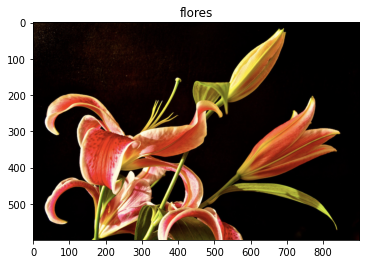

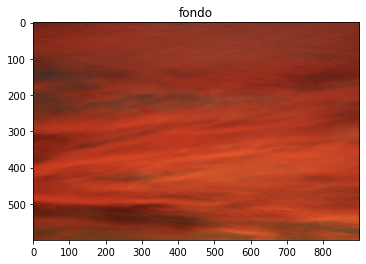

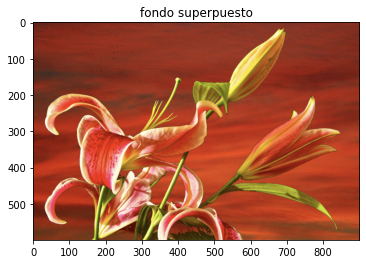

In [16]:
from PIL import Image

def poner_fondo(ruta_imagen, ruta_fondo):
    im = Image.open(ruta_imagen)
    plt.title("flores")
    plt.imshow(im)
    plt.show()
    fondo = Image.open(ruta_fondo)
    plt.title("fondo")
    plt.imshow(fondo)
    plt.show()
    x1, y1 = im.size[0], im.size[1]
    
    for j in range(y1):
        for i in range(x1):
            r, g, b = im.getpixel((i,j))[0:3]
            
            if (g + r)< 80:
                r, g, b = fondo.getpixel((i,j))[0:3]
                pixel = tuple([r, g, b])
                im.putpixel((i, j), pixel)
                
    im.save("salida_E3.png")
    plt.title("fondo superpuesto")
    plt.imshow(im)
    plt.show()

    im.close()
    fondo.close()

poner_fondo("IMG03a.png", "IMG03b.png")

si bien en el resultado es el esperado no es perfecto, puesto que parte de la flor también es pasado a fondo, así que agregando un par de restricciones basados en que la parte superior del fondo de la flor es mas lumínico que el fondo inferior y que los tonos de rojo y verde son mas propios de la flor que del fondo podemos llegar a lo siguiente:

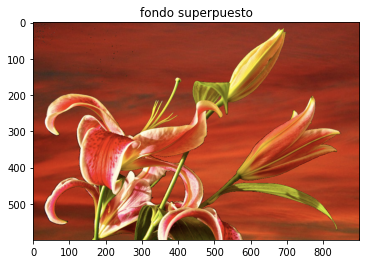

In [17]:
def poner_fondo_mejorado(ruta_imagen, ruta_fondo):
    im = Image.open(ruta_imagen)
    fondo = Image.open(ruta_fondo)
    x1, y1 = im.size[0], im.size[1]
    
    for j in range(y1):
        for i in range(x1):
            r, g, b = im.getpixel((i,j))[0:3]
            
            if  j < y1//2 and (g + r)< 80:
                r, g, b = fondo.getpixel((i,j))[0:3]
                pixel = tuple([r, g, b])
                im.putpixel((i, j), pixel)

            else:
                if (r + g) <= 34 and b <= 13:
                    r, g, b = fondo.getpixel((i,j))[0:3]
                    pixel = tuple([r, g, b])
                    im.putpixel((i, j), pixel)
                
    im.save("salida_E3.png")
    plt.title("fondo superpuesto")
    plt.imshow(im)
    plt.show()

    im.close()
    fondo.close()

poner_fondo_mejorado("IMG03a.png", "IMG03b.png")